## Predicting Peak Oil Production Rate

In this project, we will build a series of models to predict the peak oil production rate of an oil well. Predicting this quantity provides valuable
insights on the overall production profile of an oil well, which is essential for making informed decisions down the road.

## Outline

The workflow of our approach is as follows:
- Data Exploration and Pre-processing: Visualize the raw input data and observe patterns in correlation. Then, pre-process the data in a reasonable manner.
- Model Building: Construct baseline linear and non-linear models to predict the peak oil production rate.
- Evaluation: Use R-Squared and RMSE to evaluate the models and compare their performance. 
- Conclusions: Draw conclusions on performance capablity based on the evaluation phase.

## Data Exploration

There are numerous descriptive variables in our dataset. These include:
- relative_well_position
- batch_frac_classification
- frac_type
- well_family_relationship
- ffs_frac_type

In [44]:
# Import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
from typing import *

# Import libraries for machine learning
from sklearn.model_selection import train_test_split

# Import libraries for random forest
from sklearn.ensemble import RandomForestRegressor

# Import libraries for SVR
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Import libraries for metrics
from sklearn.metrics import mean_squared_error, r2_score

# Ignore warnings
warnings.simplefilter("ignore")

# Path to the training data
training_path = "./training.csv"

Start by reading in the training data and dropping any irrelevant features. Also, drop any rows that do not have an OilPeakRate value.

In [3]:
raw_df = pd.read_csv(training_path)
raw_df = raw_df.drop(columns=["Unnamed: 0", "pad_id", "standardized_operator_name", "surface_x", "surface_y", "bh_x", "bh_y", "horizontal_midpoint_x",
                                "horizontal_midpoint_y", "horizontal_toe_x", "horizontal_toe_y", "frac_type"])
raw_df = raw_df.dropna(subset=["OilPeakRate"])
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19306 entries, 0 to 29436
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gross_perforated_length       19148 non-null  float64
 1   number_of_stages              2643 non-null   float64
 2   total_proppant                17912 non-null  float64
 3   total_fluid                   17866 non-null  float64
 4   true_vertical_depth           19201 non-null  float64
 5   ffs_frac_type                 14310 non-null  object 
 6   proppant_intensity            17872 non-null  float64
 7   frac_fluid_intensity          17821 non-null  float64
 8   average_stage_length          2620 non-null   float64
 9   average_proppant_per_stage    2595 non-null   float64
 10  average_frac_fluid_per_stage  2582 non-null   float64
 11  proppant_to_frac_fluid_ratio  17501 non-null  float64
 12  frac_fluid_to_proppant_ratio  17501 non-null  float64
 13  bin_la

## Preliminary Visualization

In [4]:
all_variables_df = raw_df.dropna()
all_variables_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1996 entries, 344 to 29431
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gross_perforated_length       1996 non-null   float64
 1   number_of_stages              1996 non-null   float64
 2   total_proppant                1996 non-null   float64
 3   total_fluid                   1996 non-null   float64
 4   true_vertical_depth           1996 non-null   float64
 5   ffs_frac_type                 1996 non-null   object 
 6   proppant_intensity            1996 non-null   float64
 7   frac_fluid_intensity          1996 non-null   float64
 8   average_stage_length          1996 non-null   float64
 9   average_proppant_per_stage    1996 non-null   float64
 10  average_frac_fluid_per_stage  1996 non-null   float64
 11  proppant_to_frac_fluid_ratio  1996 non-null   float64
 12  frac_fluid_to_proppant_ratio  1996 non-null   float64
 13  bin_l

<Axes: >

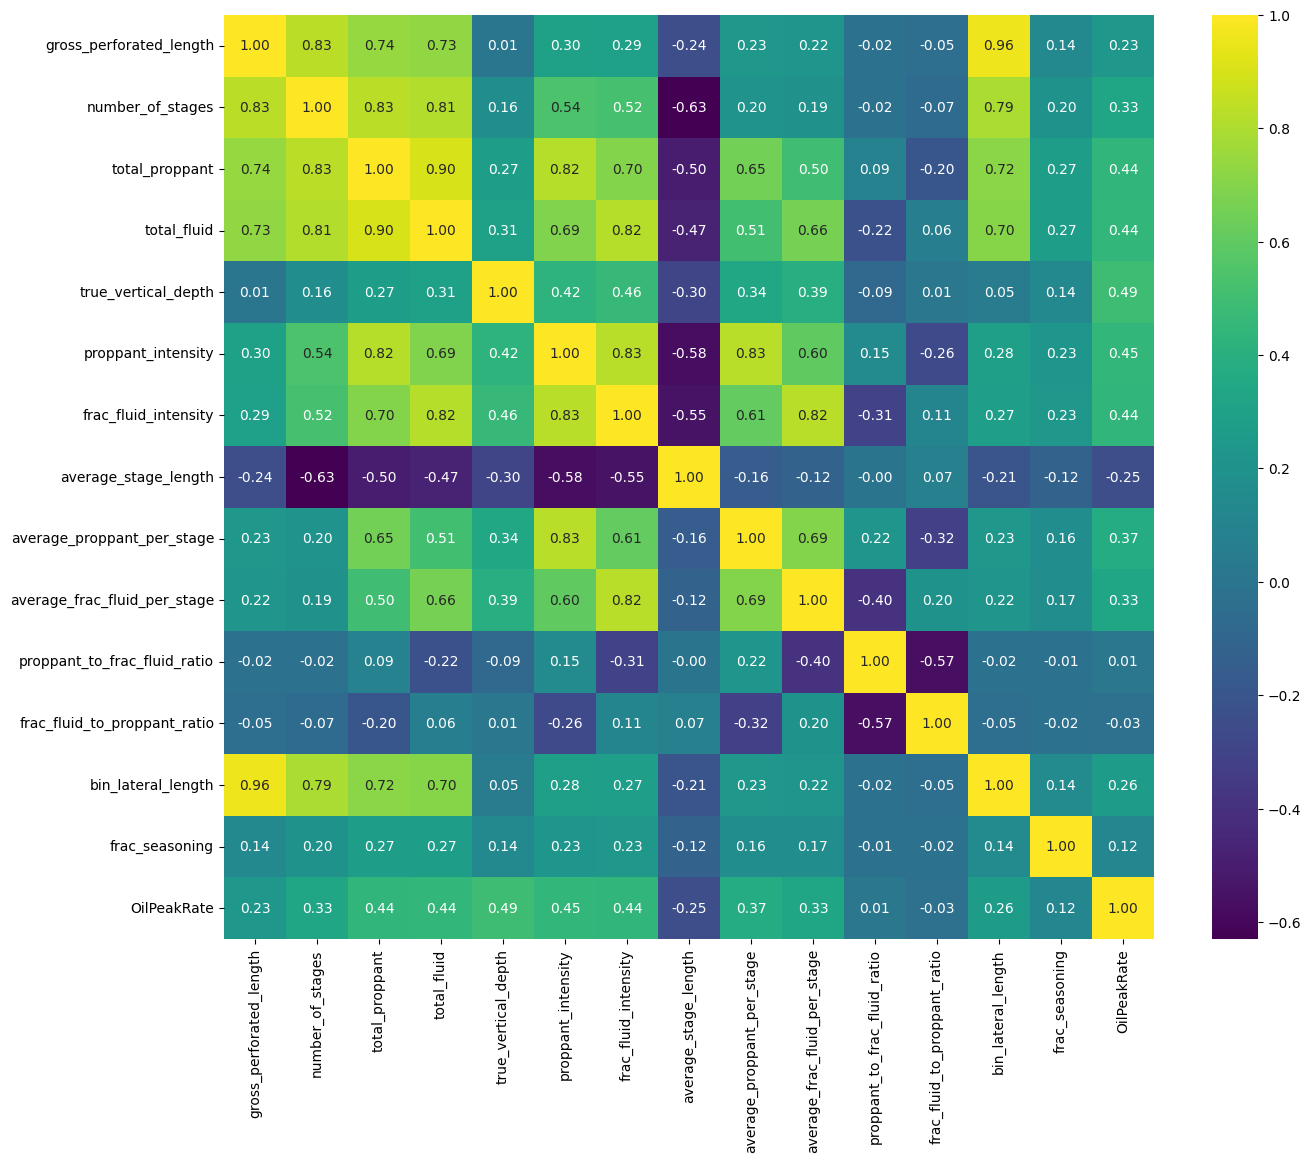

In [5]:
plt.figure(figsize=(15, 12))
# Selecting only the non-categorical variables from the DataFrame
non_categorical_data = all_variables_df.select_dtypes(include=[np.number])
sns.heatmap(non_categorical_data.corr(), annot=True, fmt=".2f", cmap='viridis')

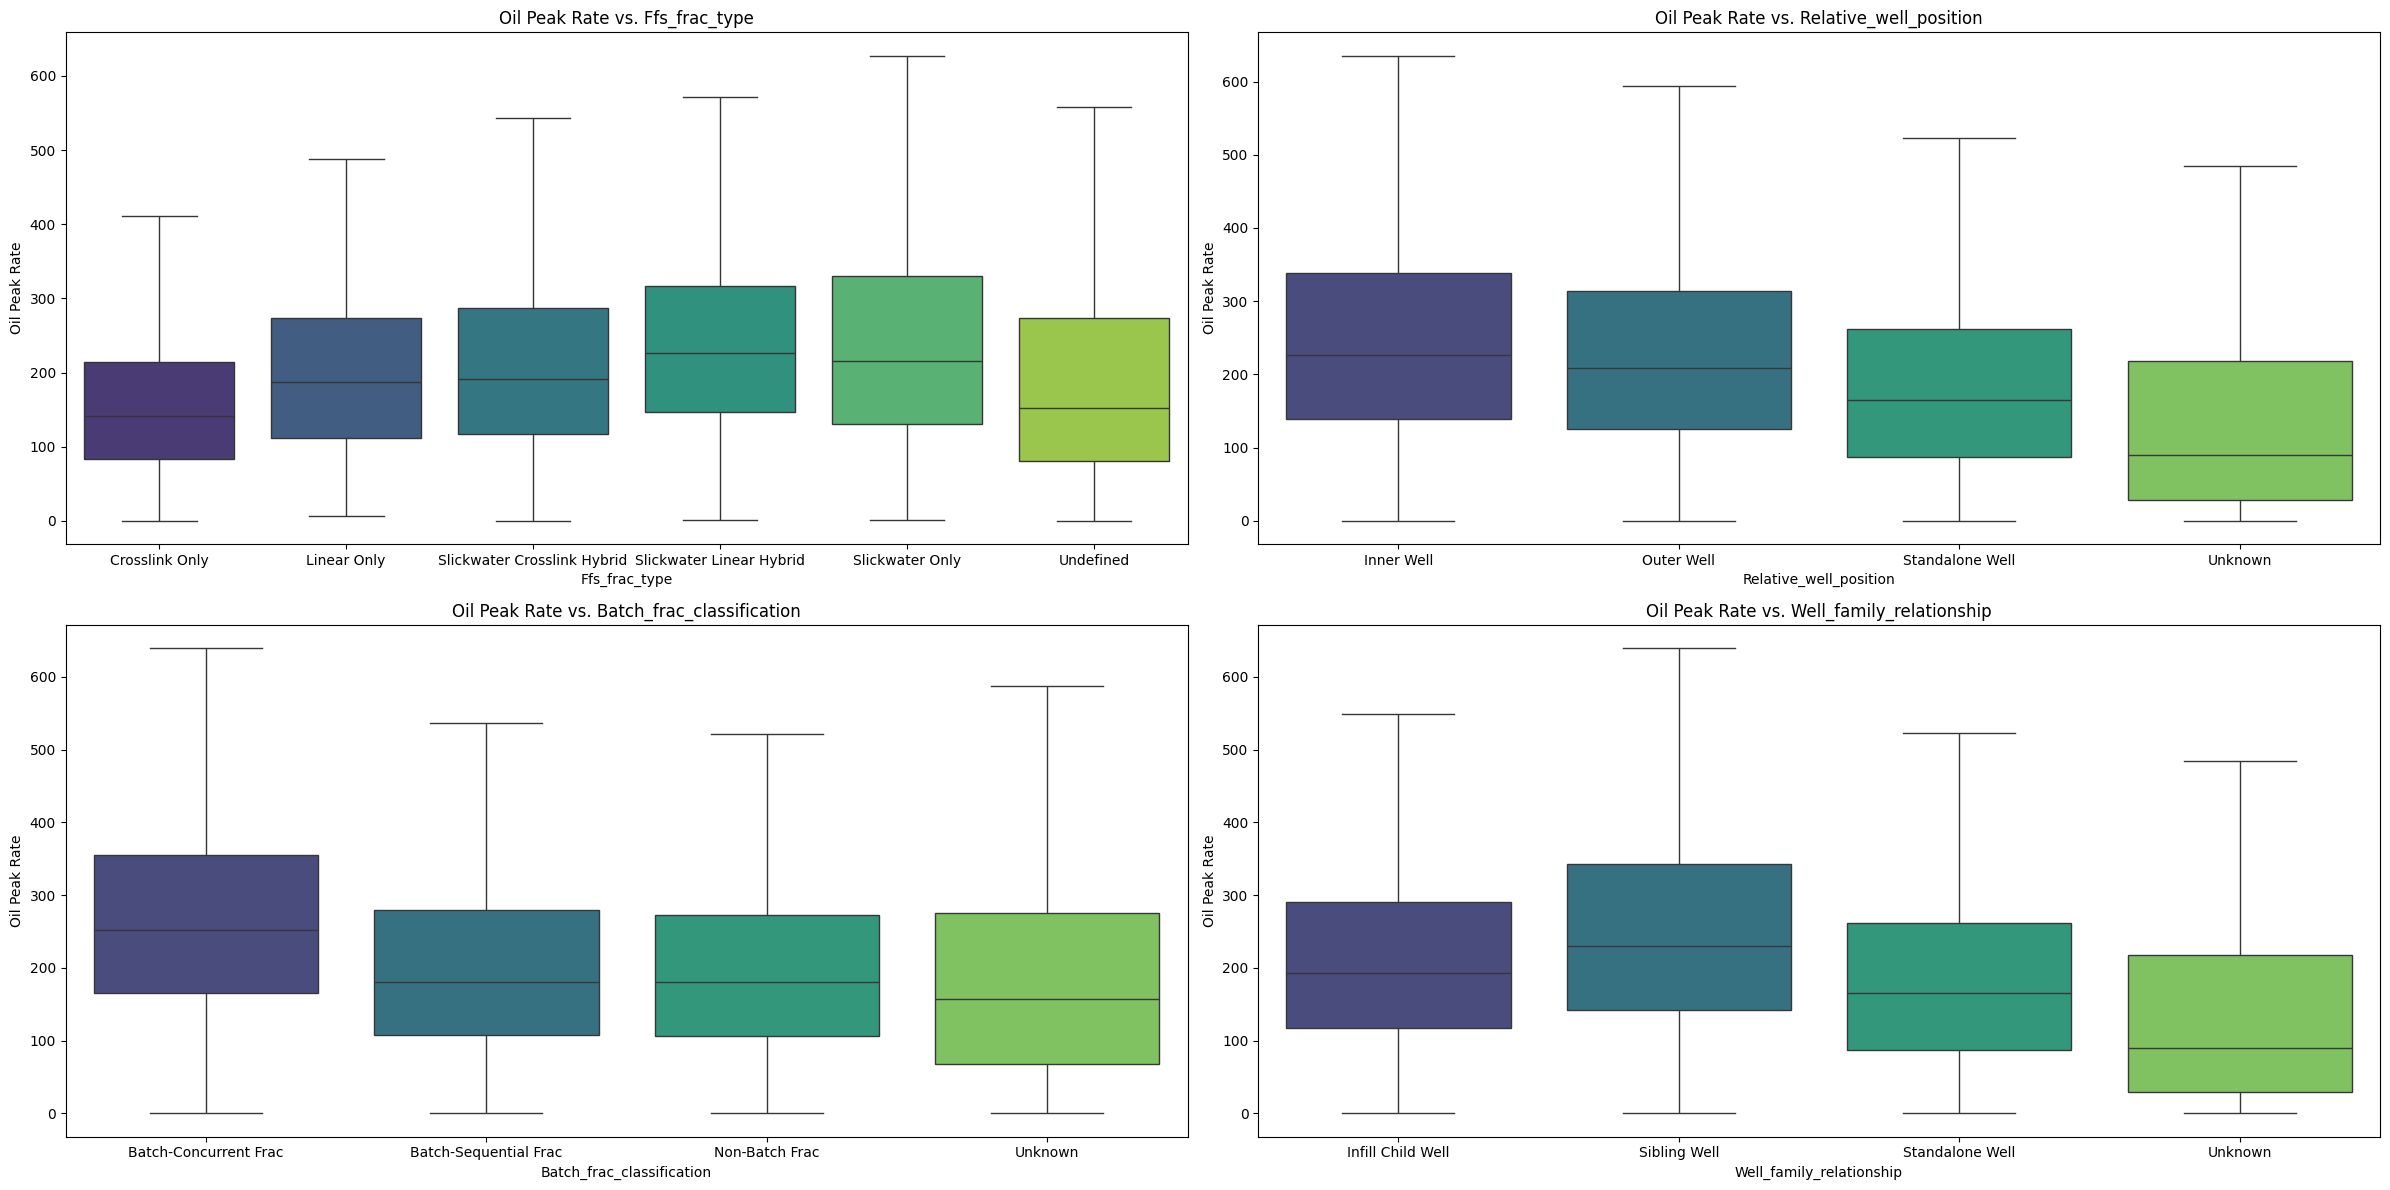

In [6]:
def visualize_categorical_variable(raw_df: pd.DataFrame, category: str, ax):
    df = raw_df.dropna(subset=[category])

    unique_values = df[category].unique()
    position_mapping = {value: index for index, value in enumerate(sorted(unique_values))}

    # Replace the category values in the DataFrame with their corresponding numeric mappings
    df[category] = df[category].replace(position_mapping)

    # Plotting on the provided axis
    sns.boxplot(data=df, x=category, y='OilPeakRate', palette='viridis', showfliers=False, ax=ax)

    # Customizing the plot
    ax.set_title(f'Oil Peak Rate vs. {category.capitalize()}')
    ax.set_xlabel(category.capitalize())
    ax.set_ylabel('Oil Peak Rate')

    ax.set_xticks(range(len(position_mapping)))
    ax.set_xticklabels(list(position_mapping.keys()))

fig, axs = plt.subplots(2, 2, figsize=(24, 12))

# Use the modified function to plot each category in one of the subplots
visualize_categorical_variable(raw_df, "ffs_frac_type", axs[0, 0])
visualize_categorical_variable(raw_df, "relative_well_position", axs[0, 1])
visualize_categorical_variable(raw_df, "batch_frac_classification", axs[1, 0])
visualize_categorical_variable(raw_df, "well_family_relationship", axs[1, 1])

# Adjust layout for better readability
plt.tight_layout()
plt.show()

In [7]:
raw_df = raw_df.drop(columns=["ffs_frac_type", "relative_well_position"])
unique_values = raw_df["batch_frac_classification"].unique()
position_mapping = {value: index for index, value in enumerate(sorted(unique_values))}

# Replace the category values in the DataFrame with their corresponding numeric mappings
raw_df["batch_frac_classification"] = raw_df["batch_frac_classification"].replace(position_mapping)

unique_values = raw_df["well_family_relationship"].unique()
position_mapping = {value: index for index, value in enumerate(sorted(unique_values))}

# Replace the category values in the DataFrame with their corresponding numeric mappings
raw_df["well_family_relationship"] = raw_df["well_family_relationship"].replace(position_mapping)

In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19306 entries, 0 to 29436
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gross_perforated_length       19148 non-null  float64
 1   number_of_stages              2643 non-null   float64
 2   total_proppant                17912 non-null  float64
 3   total_fluid                   17866 non-null  float64
 4   true_vertical_depth           19201 non-null  float64
 5   proppant_intensity            17872 non-null  float64
 6   frac_fluid_intensity          17821 non-null  float64
 7   average_stage_length          2620 non-null   float64
 8   average_proppant_per_stage    2595 non-null   float64
 9   average_frac_fluid_per_stage  2582 non-null   float64
 10  proppant_to_frac_fluid_ratio  17501 non-null  float64
 11  frac_fluid_to_proppant_ratio  17501 non-null  float64
 12  bin_lateral_length            19148 non-null  float64
 13  batch_

In [14]:
def print_corr_cols(input_df, col_1, col_2):
    """
    Prints the correlation coefficient between col_1 and col_2 in input_df.
    """
    proppant_cleaned = input_df[[col_1, col_2]].dropna()
    correlation = proppant_cleaned[col_1].corr(proppant_cleaned[col_2])
    print(f"Correlation between '{col_1}' and '{col_2}': {correlation}")
    

# Linear Regression: Test
At this stage, we will try a simple linear model to see how well it performs given our choice of filtering out certain variables.

We will drop the variables related to the number of stages ('number_of_stages', 'average_stage_length', 'average_proppant_per_stage', 'average_frac_fluid_per_stage') as we do not have enough datapoints for these variables, and we believe that the number of stages/length of each stage is captured by the 'gross_perforated_length' variable, and the proppant and frac fluid data is captured by the 'total_proppant' and 'total_fluid' variables.

In [19]:
print_corr_cols(raw_df, 'proppant_intensity', 'average_proppant_per_stage')
print_corr_cols(raw_df, 'frac_fluid_intensity', 'average_frac_fluid_per_stage')
print_corr_cols(raw_df, 'number_of_stages', 'true_vertical_depth')
print_corr_cols(raw_df, 'number_of_stages', 'gross_perforated_length')

Correlation between 'proppant_intensity' and 'average_proppant_per_stage': 0.8003615911866049
Correlation between 'frac_fluid_intensity' and 'average_frac_fluid_per_stage': 0.7979364154876065
Correlation between 'number_of_stages' and 'true_vertical_depth': 0.1766347939226918
Correlation between 'number_of_stages' and 'gross_perforated_length': 0.8314743690673992


In [24]:
stage_columns_to_drop = ['number_of_stages', 'average_stage_length', 'average_proppant_per_stage', 'average_frac_fluid_per_stage']

raw_df = raw_df.drop(columns=stage_columns_to_drop)

In [25]:
raw_df.head()

,gross_perforated_length,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,frac_fluid_intensity,proppant_to_frac_fluid_ratio,frac_fluid_to_proppant_ratio,bin_lateral_length,batch_frac_classification,well_family_relationship,frac_seasoning,OilPeakRate
0,3963.582677,76000.0000,NaN,8712.598425,19.174572,NaN,NaN,NaN,1.0,3,2,NaN,46.623023
1,3179.133858,113000.0000,5.610964e+05,8627.952756,35.544272,176.493480,0.201391,4.965455,1.0,3,0,NaN,59.750009
2,3810.039370,286571.4286,1.621424e+06,8801.181102,75.214821,425.566078,0.176741,5.658008,1.0,2,2,92.0,10.785716
3,3723.425197,106878.9286,4.377134e+05,8635.826772,28.704465,117.556659,0.244176,4.095414,1.0,3,2,NaN,123.797638
4,3811.023622,112789.7143,6.229802e+05,8664.370079,29.595648,163.467933,0.181049,5.523377,1.0,3,0,NaN,102.309540


In [26]:
raw_df.shape

(19306, 13)

In [28]:
count_nan_rows = raw_df[raw_df.isna().any(axis=1)].shape[0]
print('Number of rows with at least one NaN value:', count_nan_rows)

Number of rows with at least one NaN value: 5278


In [29]:
# As we have no way of filling in unknown values, we decide to drop all rows with at least one NaN value.
raw_df.dropna(inplace=True)

In [30]:
raw_df.shape

(14028, 13)

In [31]:
raw_df.head()

,gross_perforated_length,total_proppant,total_fluid,true_vertical_depth,proppant_intensity,frac_fluid_intensity,proppant_to_frac_fluid_ratio,frac_fluid_to_proppant_ratio,bin_lateral_length,batch_frac_classification,well_family_relationship,frac_seasoning,OilPeakRate
2,3810.039370,286571.4286,1.621424e+06,8801.181102,75.214821,425.566078,0.176741,5.658008,1.0,2,2,92.0,10.785716
35,4017.716535,135363.7857,1.016599e+06,8605.314961,33.691721,253.028965,0.133154,7.510123,1.0,2,0,28.0,83.512989
39,3355.314961,111142.8571,5.621877e+05,8718.503937,33.124419,167.551386,0.197697,5.058244,1.0,2,2,31.0,35.415958
44,3786.417323,93000.0000,6.713527e+05,8544.291339,24.561476,177.305525,0.138526,7.218846,1.0,2,1,20.0,207.392492
45,3535.433071,117142.8571,4.401761e+05,8627.952756,33.133948,124.504147,0.266127,3.757601,1.0,2,0,53.0,34.520720


In [32]:
raw_df.to_csv('cleaned_training_nostages.csv', index=False)

In [39]:
infinity_mask = np.isinf(raw_df)

rows_with_infinity = raw_df[infinity_mask.any(axis=1)]
print('Rows with at least one infinity value:', rows_with_infinity)

Rows with at least one infinity value: Empty DataFrame
Columns: [gross_perforated_length, total_proppant, total_fluid, true_vertical_depth, proppant_intensity, frac_fluid_intensity, proppant_to_frac_fluid_ratio, frac_fluid_to_proppant_ratio, bin_lateral_length, batch_frac_classification, well_family_relationship, frac_seasoning, OilPeakRate]
Index: []


In [38]:
# We drop all rows with any infinity values, as we are unsure the exact ratio of frac fluid to proppants in this case.
raw_df.replace([np.inf, -np.inf], np.nan, inplace=True)

raw_df = raw_df.dropna()

We now attempt to train a random forest regressor on the input dataset.

In [40]:
X = raw_df.drop('OilPeakRate', axis=1)
y = raw_df['OilPeakRate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

Mean squared error: 12236.823005329483


In [43]:
r2 = r2_score(y_test, y_pred)
print(f'r^2 score: {r2}')

r^2 score: 0.478978035452456


In [45]:
# Scale data for SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
# Create an SVR model
svr_model = SVR(kernel='linear', C=1.0)

# Train the model
svr_model.fit(X_train_scaled, y_train)

SVR(kernel='linear')

In [47]:
y_pred_scr = svr_model.predict(X_test_scaled)

In [49]:
mse = mean_squared_error(y_test, y_pred_scr)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 16617.74928886379
